<a href="https://colab.research.google.com/github/ReidelVichot/PUS2022_RVichot/blob/main/HW4/Geospatial_NYCCitiBike_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# reproducible Spatial Data Analysis with pandas
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

Use this notebook we examined in class 
https://github.com/fedhere/PUS2022_FBianco/blob/main/classdemo/PhillyCitiBikes_partiallyFilledNotebook.ipynb

as well as the notebooks we wrote together 
https://github.com/fedhere/PUS2022_FBianco/blob/main/classdemo/Part_I_GeospatialAnalysis_CitiBike.ipynb

# 0 Install geospatial libraries

In [ ]:
!apt install python3-rtree 
!pip install geopandas


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 0.1 Import initial libraries

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
import rtree

# 1 Working with a Shape File of Census Tracts

### 1.1 Loading Census Tract GeoJSON File


In [ ]:
ct_shape = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=GeoJSON")

In [ ]:
ct_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      2165 non-null   object  
 1   shape_area   2165 non-null   object  
 2   ntaname      2165 non-null   object  
 3   shape_leng   2165 non-null   object  
 4   boro_name    2165 non-null   object  
 5   puma         2165 non-null   object  
 6   ct2010       2165 non-null   object  
 7   boro_code    2165 non-null   object  
 8   cdeligibil   2164 non-null   object  
 9   boro_ct2010  2165 non-null   object  
 10  ctlabel      2165 non-null   object  
 11  geometry     2165 non-null   geometry
dtypes: geometry(1), object(11)
memory usage: 203.1+ KB


## 1.2 Coordinate systems, projections, and transformations : 

### Visualize the Census Tract boundaries colored by boroughs

the file you read in into a geodataframe, which I will call generically ```gpd``` in these instructions, contains the "boro_code" column. To color by a column value (and the column can be numerical or categorical) you pass the column name to ```gdp.plot``` as
```gdp.plot(column="columnName")```

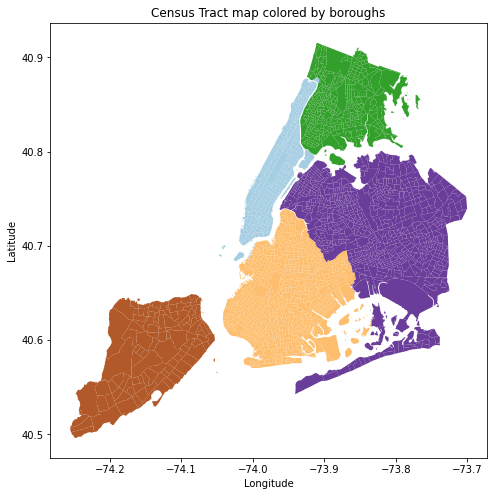

In [ ]:
f, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ct_shape.plot(column='boro_code', alpha=1, linewidth=0.5,
              ax=ax, cmap='Paired')
plt.title("Census Tract map colored by boroughs");

Caption: This map shows 2011 census tracts colored according to in which of the five boroughs of New York City the census tract is.

### Measure Areas

As discussed in class, you cannot use coordinates in latitude and longitude degree units to measure areas of polygons: you need first to project on a plane.

* Convert the coordinates of  your geodataframe, here referred to  as gpd, to a projected EPSG:2263 which is coordinated in feet, instead of lat long degrees. centered near NYC

  use 

```gpd.to_crs("EPSG:2263")```

* Extract the area of each gemetry : the geometry column has many relevant methods. use (as we did in class)

```gpd.geometry.area```

* Create a new column in your dataframe called "shape_areami2" and set it equal to the area of the polygon in miles squared. the feet to miles conversion is here 
https://www.google.com/search?sxsrf=ALeKk03B4ThQrJJXpFzoCrgRfrJ1nByPMg%3A1600870977934&ei=QVprX9muOIOl_QbOtaOwCQ&q=feet+to+mile&oq=feet+to+mile&gs_lcp=CgZwc3ktYWIQAzIICAAQsQMQkQIyAggAMgIIADICCAAyAggAMgIIADICCAAyAggAMgIIADICCAA6BAgAEEc6BAgjECc6BQgAELEDOgoIABCxAxAUEIcCUM_1AVjK-AFgzPoBaABwAngAgAFkiAHvApIBAzMuMZgBAKABAaoBB2d3cy13aXrIAQjAAQE&sclient=psy-ab&ved=0ahUKEwiZ0-GPvf_rAhWDUt8KHc7aCJYQ4dUDCA0&uact=5


* Calculate the total area of NYC in miles squared. 

* On epsg.io  look up the EPSG:2263. What is the accuracy when this projection is used in NYC?



In [ ]:
import numpy as np
np.square(2)

4

In [ ]:
ct_shape = ct_shape.to_crs("EPSG:2263")
ct_shape["shape_areami2"] = ct_shape.geometry.area * np.square(1/5280)

In [ ]:

NYC_Area = ct_shape["shape_areami2"].sum()
print ('total NYC land area: {:.0f} (mi^2)'.format(NYC_Area)) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302 (mi^2)


### Choropleths of NYC

a choropleth is a map where the color of a polygon is mapped to a value. Perhaps the easiest thing to envision is to map the color to the size of the polygon. To make a choropleth of your python geodataframe (gdp) you can use, like before but this time with a numerical column:

```gdp.plot(column="theNameOfMyColumn")```

The problem is that the column has to be numeric. I want you to use "shape_area" but "shape_area" is not directly read in as a numerical column (you can tell when you run gdp.info(): it says its a type "object").

Convert gdp["shape_area"] to numeric by passing it to the pandas function

```pd.to_numeric()``` with the argument 

```error="coerce"```

https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html




In [ ]:
ct_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ntacode        2165 non-null   object  
 1   shape_area     2165 non-null   object  
 2   ntaname        2165 non-null   object  
 3   shape_leng     2165 non-null   object  
 4   boro_name      2165 non-null   object  
 5   puma           2165 non-null   object  
 6   ct2010         2165 non-null   object  
 7   boro_code      2165 non-null   object  
 8   cdeligibil     2164 non-null   object  
 9   boro_ct2010    2165 non-null   object  
 10  ctlabel        2165 non-null   object  
 11  geometry       2165 non-null   geometry
 12  shape_areami2  2165 non-null   float64 
dtypes: float64(1), geometry(1), object(11)
memory usage: 220.0+ KB


In [ ]:
ct_shape["shape_area"] = pd.to_numeric(ct_shape["shape_area"], errors="coerce")
ct_shape.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ntacode        2165 non-null   object  
 1   shape_area     2165 non-null   float64 
 2   ntaname        2165 non-null   object  
 3   shape_leng     2165 non-null   object  
 4   boro_name      2165 non-null   object  
 5   puma           2165 non-null   object  
 6   ct2010         2165 non-null   object  
 7   boro_code      2165 non-null   object  
 8   cdeligibil     2164 non-null   object  
 9   boro_ct2010    2165 non-null   object  
 10  ctlabel        2165 non-null   object  
 11  geometry       2165 non-null   geometry
 12  shape_areami2  2165 non-null   float64 
dtypes: float64(2), geometry(1), object(10)
memory usage: 220.0+ KB


* make a coropleth using "shape_area"

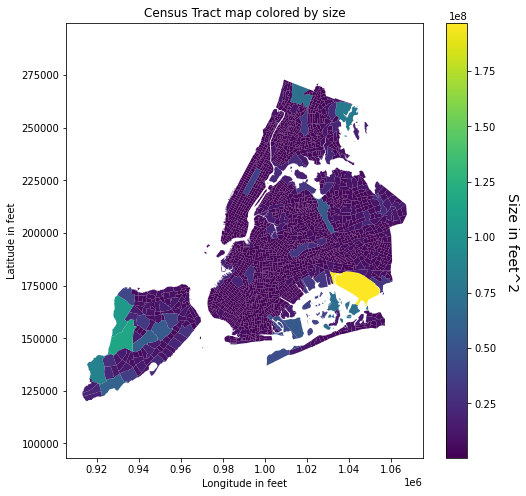

In [ ]:
f, ax = plt.subplots(figsize=[8,8])
ax.set_xlabel("Longitude in feet")
ax.set_ylabel("Latitude in feet")
ax.set_title("Census Tract map colored by size")
ax.axis("equal") # Matches the sixe of the legend bar with the size of the axis.
f.text(0.9, 0.5, "Size in feet^2", rotation =-90, fontsize=14, ha="center", va="center")
ct_shape.plot(column="shape_area", legend=True, ax=ax)
f.show()






Caption: This map shows NYC's 2011 census tracts colored according to the size in feet-squared.

* Now use your column "shape_areami2" - the colors should be mapped the same way

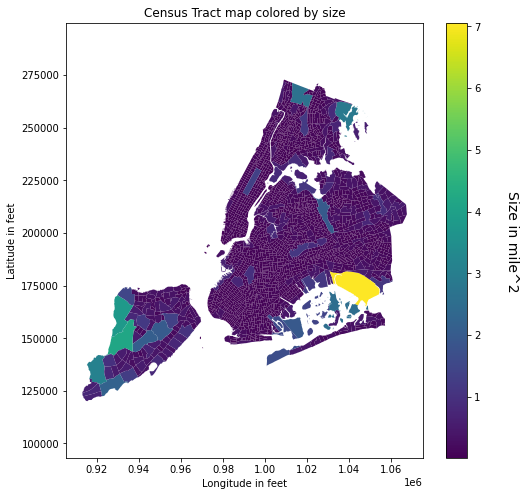

In [ ]:
f, ax = plt.subplots(figsize=[8,8])
ax.set_xlabel("Longitude in feet")
ax.set_ylabel("Latitude in feet")
ax.set_title("Census Tract map colored by size")
ax.axis("equal") # Matches the sixe of the legend bar with the size of the axis.
f.text(0.9, 0.5, "Size in mile^2", rotation =-90, fontsize=14, ha="center", va="center")
ct_shape.plot(column="shape_areami2", legend=True, ax=ax)
f.show()


Caption: This map shows NYC's 2011 census tracts colored according to the size in squared miles.

* Now lets put some numerical values to the colors. you can do by adding the argument 

```legend=True```

 to the choropleth gdp.plot() call

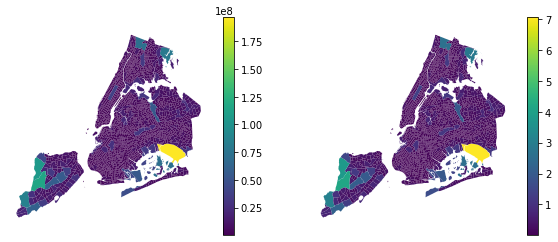

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ct_shape.plot(column="shape_area", legend=True, ax=ax)
ax.axis('off');
ax = fig.add_subplot(122)
ct_shape.plot(column="shape_areami2", legend=True, ax=ax)
ax.axis('off');

Caption: This maps compare NYC's 2011 census tracts colored according to the size in squared feet (left image) and in squared miles (right image).

Often a more useful way to read numers associated to colors is to use quantiles. For this yuo need to install 

```mapclassify```

In [ ]:
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Use mapclassify to plot the distribution quartiles

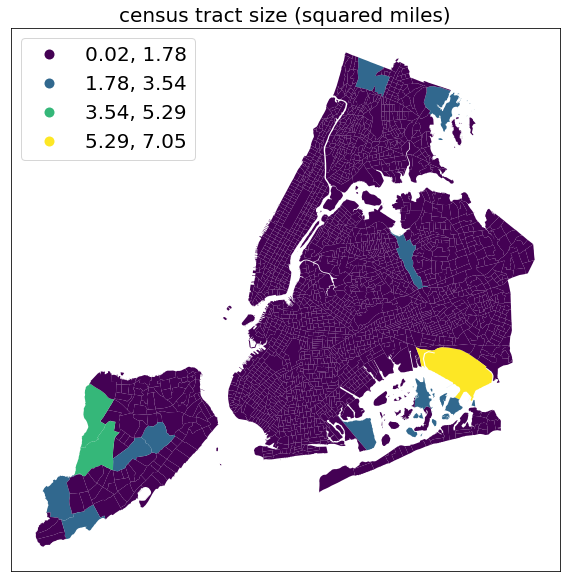

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='shape_areami2', cmap='viridis', alpha=1,
              linewidth=0.1, ax=ax, scheme="Equal_interval", 
              legend=True, k=4, legend_kwds={'loc': 'upper left', 'fontsize':20});
plt.title("census tract size (squared miles)", fontsize=20);

Caption: This maps shows NYC's 2011 census tracts colored according to the size in squared miles. In this image, each color is associated with a range of size, or, in other words, quartiles.

(At some point i got so tired of moving the legend around that i made a whole package to plot choropleths of NYC https://github.com/fedhere/choroplethNYC )

# 2 Explore CitiBike data

### 2.1 Load CitiBike data for 9/2013

In [ ]:
cb201609 = pd.read_csv('https://s3.amazonaws.com/tripdata/201609-citibike-tripdata.zip', index_col='starttime')
cb201609.head()

,tripduration,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
starttime,,,,,,,,,,,,,,
9/1/2016 00:00:02,975,9/1/2016 00:16:18,312,Allen St & Stanton St,40.722055,-73.989111,313,Washington Ave & Park Ave,40.696102,-73.967510,22609,Subscriber,1985.0,1
9/1/2016 00:00:04,1220,9/1/2016 00:20:25,316,Fulton St & William St,40.709560,-74.006536,239,Willoughby St & Fleet St,40.691966,-73.981302,16966,Subscriber,1977.0,2
9/1/2016 00:00:19,308,9/1/2016 00:05:27,479,9 Ave & W 45 St,40.760193,-73.991255,448,W 37 St & 10 Ave,40.756604,-73.997901,25601,Subscriber,1983.0,1
9/1/2016 00:00:25,250,9/1/2016 00:04:35,297,E 15 St & 3 Ave,40.734232,-73.986923,487,E 20 St & FDR Drive,40.733143,-73.975739,22094,Subscriber,1953.0,1
9/1/2016 00:00:25,439,9/1/2016 00:07:45,494,W 26 St & 8 Ave,40.747348,-73.997236,533,Broadway & W 39 St,40.752996,-73.987216,16319,Subscriber,1985.0,1


## 2.2 Explore the dataset, you know how!

In [ ]:
print(cb201609.info())
print(cb201609.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1648856 entries, 9/1/2016 00:00:02 to 9/30/2016 23:59:51
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   tripduration             1648856 non-null  int64  
 1   stoptime                 1648856 non-null  object 
 2   start station id         1648856 non-null  int64  
 3   start station name       1648856 non-null  object 
 4   start station latitude   1648856 non-null  float64
 5   start station longitude  1648856 non-null  float64
 6   end station id           1648856 non-null  int64  
 7   end station name         1648856 non-null  object 
 8   end station latitude     1648856 non-null  float64
 9   end station longitude    1648856 non-null  float64
 10  bikeid                   1648856 non-null  int64  
 11  usertype                 1648856 non-null  object 
 12  birth year               1433341 non-null  float64
 13  gender              

## 2.3 Map CitiBike Data at the census tract level

### Create a stations dataframe with spatial info
 
this is done alrady in the notebook we reviewed in class. The steps are:

* groupby station and take the first row of wach group with 

```gdp.groupby("...").first()```

* call your new dataframe "cbstations"

In [ ]:
cbstations = cb201609.groupby("start station id").first()
cbstations.head()

,tripduration,stoptime,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
start station id,,,,,,,,,,,,,
72,944,9/1/2016 00:41:52,W 52 St & 11 Ave,40.767272,-73.993929,453,W 22 St & 8 Ave,40.744751,-73.999154,22738,Subscriber,1989.0,2
79,303,9/1/2016 07:13:30,Franklin St & W Broadway,40.719116,-74.006667,152,Warren St & Church St,40.714740,-74.009106,19043,Subscriber,1984.0,2
82,208,9/1/2016 00:46:55,St James Pl & Pearl St,40.711174,-74.000165,331,Pike St & Monroe St,40.711731,-73.991930,25627,Subscriber,1989.0,1
83,301,9/1/2016 00:44:26,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,3416,7 Ave & Park Pl,40.677615,-73.973243,18079,Subscriber,1980.0,2
116,858,9/1/2016 00:15:31,W 17 St & 8 Ave,40.741776,-74.001497,116,W 17 St & 8 Ave,40.741776,-74.001497,18605,Subscriber,1988.0,1


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

from each pair of latitude and longitude coordinates for the start station make a shapely Point object (see https://github.com/fedhere/PUS2022_FBianco/blob/main/classdemo/PhillyCitiBikes_partiallyFilledNotebook.ipynb)

In [ ]:
cbstations['lonlat'] = cbstations.apply(lambda x: Point(x["start station longitude"], x["start station latitude"]), axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
cbstations.head()

,tripduration,stoptime,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,lonlat
start station id,,,,,,,,,,,,,,
72,944,9/1/2016 00:41:52,W 52 St & 11 Ave,40.767272,-73.993929,453,W 22 St & 8 Ave,40.744751,-73.999154,22738,Subscriber,1989.0,2,POINT (-73.99392888 40.76727216)
79,303,9/1/2016 07:13:30,Franklin St & W Broadway,40.719116,-74.006667,152,Warren St & Church St,40.714740,-74.009106,19043,Subscriber,1984.0,2,POINT (-74.00666661 40.71911552)
82,208,9/1/2016 00:46:55,St James Pl & Pearl St,40.711174,-74.000165,331,Pike St & Monroe St,40.711731,-73.991930,25627,Subscriber,1989.0,1,POINT (-74.00016545 40.71117416)
83,301,9/1/2016 00:44:26,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,3416,7 Ave & Park Pl,40.677615,-73.973243,18079,Subscriber,1980.0,2,POINT (-73.97632328 40.68382604)
116,858,9/1/2016 00:15:31,W 17 St & 8 Ave,40.741776,-74.001497,116,W 17 St & 8 Ave,40.741776,-74.001497,18605,Subscriber,1988.0,1,POINT (-74.00149746 40.74177603)


### plot the stations

* Turn the dataframe into a geodataframe (as I did in class in the example above)

* Every geodataframe needs a geometry column: assign latlon to the "geometry"

* Set the crs to “EPSG:4326” with 
```gdp.set_crs()```

* Plot the locations of the stations

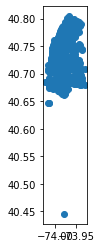

In [ ]:
cbstations = gpd.GeoDataFrame(cbstations)
cbstations["geometry"] = cbstations["lonlat"]
cbstations = cbstations.set_crs("EPSG:4326")
cbstations.plot()

Caption: Spacial distribution of bike stations. It seems that there is a station that is far South, it is far from the other stations, this could be a data error.

convert the geometry projection to the same one you used for the NYC census tracts and replot with the census tracts map in the background


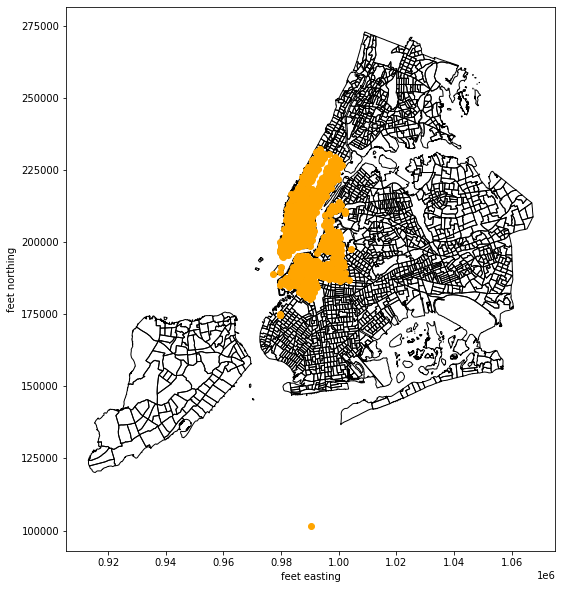

In [ ]:
cbstations = cbstations.to_crs("EPSG:2263")
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
#ct_shape.boundary.plot(ax=ax, alpha=0.5)
ct_shape.plot(ax=ax, color="None", edgecolor='k')
cbstations.plot(ax=ax, c='orange');

Caption: Location of bike stations on census tracts. The station that seemed very far from most of the stations seems to be completely ouside the NYC ct area. Therefore we can confirm that it is a data error. 

### cleaning data

Clearly there is an data stored incorrectly: that station at the bottom is in the water. Remove it by selecting "start station latitude" greater than some appropriate value and replot

In [ ]:
cbstations

,tripduration,stoptime,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,lonlat,geometry
start station id,,,,,,,,,,,,,,,
72,944,9/1/2016 00:41:52,W 52 St & 11 Ave,40.767272,-73.993929,453,W 22 St & 8 Ave,40.744751,-73.999154,22738,Subscriber,1989.0,2,POINT (-73.99392888 40.76727216),POINT (985931.707 218814.757)
79,303,9/1/2016 07:13:30,Franklin St & W Broadway,40.719116,-74.006667,152,Warren St & Church St,40.714740,-74.009106,19043,Subscriber,1984.0,2,POINT (-74.00666661 40.71911552),POINT (982402.007 201269.770)
82,208,9/1/2016 00:46:55,St James Pl & Pearl St,40.711174,-74.000165,331,Pike St & Monroe St,40.711731,-73.991930,25627,Subscriber,1989.0,1,POINT (-74.00016545 40.71117416),POINT (984204.132 198376.421)
83,301,9/1/2016 00:44:26,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,3416,7 Ave & Park Pl,40.677615,-73.973243,18079,Subscriber,1980.0,2,POINT (-73.97632328 40.68382604),POINT (990816.693 188413.578)
116,858,9/1/2016 00:15:31,W 17 St & 8 Ave,40.741776,-74.001497,116,W 17 St & 8 Ave,40.741776,-74.001497,18605,Subscriber,1988.0,1,POINT (-74.00149746 40.74177603),POINT (983835.043 209525.635)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431,1207,9/14/2016 21:20:15,E 35 St & 3 Ave,40.746524,-73.977885,3135,E 75 St & 3 Ave,40.771129,-73.957723,25842,Subscriber,1987.0,1,POINT (-73.977885 40.746524),POINT (990377.786 211256.242)
3432,1441,9/22/2016 18:43:12,Bike in Movie Night | Prospect Park Bandshell,40.662987,-73.976918,282,Kent Ave & S 11 St,40.707645,-73.968415,27170,Subscriber,1986.0,2,POINT (-73.976918 40.662987),POINT (990653.749 180821.277)
3434,346,9/30/2016 17:32:32,W 88 St & West End Ave,40.790254,-73.977183,3360,Amsterdam Ave & W 79 St,40.782939,-73.978652,25892,Subscriber,1968.0,2,POINT (-73.97718340158461 40.79025417330419),POINT (990568.040 227188.645)


In [ ]:
cbstations = cbstations[cbstations["start station latitude"]>40.50]

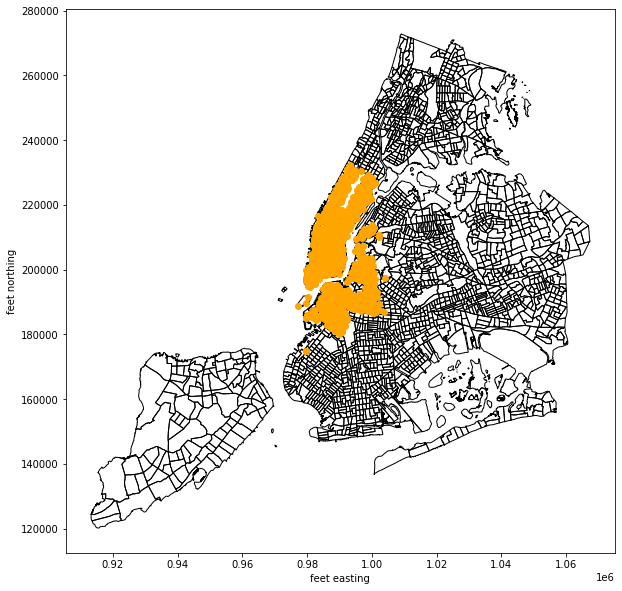

In [ ]:
#replot
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
#ct_shape.boundary.plot(ax=ax, alpha=0.5)
ct_shape.plot(ax=ax, color="None", edgecolor='k')
cbstations.plot(ax=ax, c='orange');

Caption: This map shows all the bike stations under study and the ct. Many of the ct do not have bike stations. Therefore, it would be helpful to zoom-in the map in order to capture more information on the areas that do have bike stations. 

### zoom into the relevant area 

zoom-in into the relevant area using ```ax.set_xlim()``` and ```ax.set_ylim()```

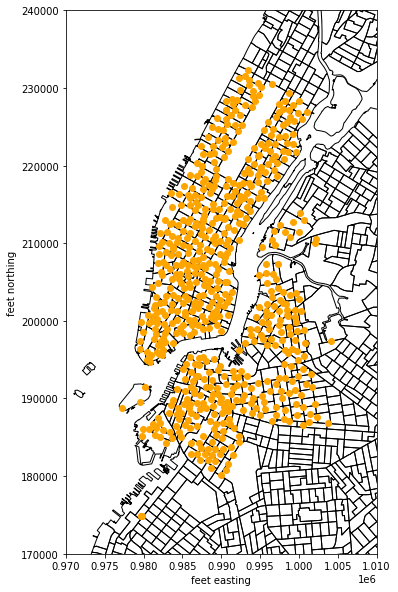

In [ ]:
#replot
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
#ct_shape.boundary.plot(ax=ax, alpha=0.5)
ct_shape.plot(ax=ax, color="None", edgecolor='k')
ax.set_xlim(0.97*1e6,1.01*1e6)
ax.set_ylim(170000,240000)

cbstations.plot(ax=ax, c='orange');

Caption: This map shows the bike stations by census tract in New York City.

# 3 Assigning points to polygons


## 3.1 Assign each station to a Borough

### Intrsect the census tract and citi bikes geometries manually

``` gdp.ct_shape.geometry.intersect```

First, let me do this by intersecting the shapes "manually" in a for loop. This should be transparent as far as the syntax go but it is very computationally inefficient


In [ ]:
cbstations["boro_name"] = ''
# check for each citibike stations to see what CT they are belong to
for i in cbstations.index:
    a = ct_shape[ct_shape.geometry.intersects(
        cbstations.loc[i].geometry)]["boro_name"].values[0]
    
    cbstations.loc[i,'boro_name'] = a


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
cbstations.head()

,tripduration,stoptime,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,lonlat,geometry,boro_name
start station id,,,,,,,,,,,,,,,,
72,944,9/1/2016 00:41:52,W 52 St & 11 Ave,40.767272,-73.993929,453,W 22 St & 8 Ave,40.744751,-73.999154,22738,Subscriber,1989.0,2,POINT (-73.99392888 40.76727216),POINT (985931.707 218814.757),Manhattan
79,303,9/1/2016 07:13:30,Franklin St & W Broadway,40.719116,-74.006667,152,Warren St & Church St,40.714740,-74.009106,19043,Subscriber,1984.0,2,POINT (-74.00666661 40.71911552),POINT (982402.007 201269.770),Manhattan
82,208,9/1/2016 00:46:55,St James Pl & Pearl St,40.711174,-74.000165,331,Pike St & Monroe St,40.711731,-73.991930,25627,Subscriber,1989.0,1,POINT (-74.00016545 40.71117416),POINT (984204.132 198376.421),Manhattan
83,301,9/1/2016 00:44:26,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,3416,7 Ave & Park Pl,40.677615,-73.973243,18079,Subscriber,1980.0,2,POINT (-73.97632328 40.68382604),POINT (990816.693 188413.578),Brooklyn
116,858,9/1/2016 00:15:31,W 17 St & 8 Ave,40.741776,-74.001497,116,W 17 St & 8 Ave,40.741776,-74.001497,18605,Subscriber,1988.0,1,POINT (-74.00149746 40.74177603),POINT (983835.043 209525.635),Manhattan


### overplot the map locations on top of the census tract boundaries in the zoom in version (as before) but this time color the points by NYC Borough

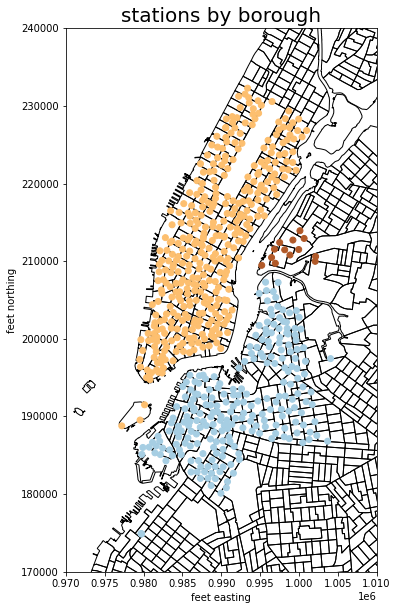

In [ ]:
#replot
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
ax.set_xlim(0.97*1e6,1.01*1e6)
ax.set_ylim(170000,240000)
ct_shape.plot(ax=ax, color="None", edgecolor='k')
#ct_shape.boundary.plot(ax=ax, alpha=0.5, color="k")
cbstations.plot(column='boro_name', alpha=1,
              ax=ax, cmap='Paired')

plt.title("stations by borough", fontsize=20);




Caption: This map shows the bike stations by census tract in New York City. The stations are colored according to the borough.

## 3.2 create a colopleth of NYC census tracts where the color maps to the number of citibike stations


### Perform a spatial join

Perfoming an $n \times m$ intersection test is horrifically inefficient and slow. Spatial joins use an R-tree for spatial indexing to rapidly join the tables on their geometries. 

Spatial joins operate on objects with eastings and northings, i.e., you must use two geodataframs with the same CRS, and that needs ot be a CRS expressed with dimensioned lengths. This will NOT work on data expressed in lat/long.

use 

```geopandas.tools.sjoin()``` 
passing to it ct_shape and cbstations to get a dataframe that for every station row has the census tract value in a ```boro_ct2010``` column

In [ ]:
ct_shape.crs == cbstations.crs

True

In [ ]:
print(ct_shape.head(1))
print(cbstations.head(1))

  ntacode    shape_area                                    ntaname  \
0    SI22  2.497010e+06  West New Brighton-New Brighton-St. George   

      shape_leng      boro_name  puma  ct2010 boro_code cdeligibil  \
0  7729.01679383  Staten Island  3903  000900         5          E   

  boro_ct2010 ctlabel                                           geometry  \
0     5000900       9  MULTIPOLYGON (((962269.126 173705.500, 962288....   

   shape_areami2  
0       0.089568  
                  tripduration           stoptime start station name  \
start station id                                                       
72                         944  9/1/2016 00:41:52   W 52 St & 11 Ave   

                  start station latitude  start station longitude  \
start station id                                                    
72                             40.767272               -73.993929   

                  end station id end station name  end station latitude  \
start station id           

In [ ]:
cbstationsWct = gpd.tools.sjoin(ct_shape, cbstations)
cbstationsWct

,ntacode,shape_area,ntaname,shape_leng,boro_name_left,puma,ct2010,boro_code,cdeligibil,boro_ct2010,...,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,lonlat,boro_name_right
1,MN19,1.906016e+06,Turtle Bay-East Midtown,5534.20030825,Manhattan,3808,009800,1,I,1009800,...,3140,1 Ave & E 78 St,40.771404,-73.953517,19938,Customer,1990.0,0,POINT (-73.96592976 40.75455731),Manhattan
1,MN19,1.906016e+06,Turtle Bay-East Midtown,5534.20030825,Manhattan,3808,009800,1,I,1009800,...,401,Allen St & Rivington St,40.720196,-73.989978,15618,Subscriber,1992.0,1,POINT (-73.967416 40.756014),Manhattan
2,MN17,1.860993e+06,Midtown-Midtown South,5687.80243891,Manhattan,3807,010200,1,I,1010200,...,530,11 Ave & W 59 St,40.771522,-73.990541,24994,Subscriber,1965.0,1,POINT (-73.97402311 40.7597108),Manhattan
2,MN17,1.860993e+06,Midtown-Midtown South,5687.80243891,Manhattan,3807,010200,1,I,1010200,...,305,E 58 St & 3 Ave,40.760958,-73.967245,25802,Subscriber,1986.0,1,POINT (-73.972924 40.761628),Manhattan
3,MN17,1.864600e+06,Midtown-Midtown South,5693.03636707,Manhattan,3807,010400,1,I,1010400,...,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,20969,Subscriber,1986.0,1,POINT (-73.97648516 40.75992262),Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,BK99,2.740340e+07,park-cemetery-etc-Brooklyn,24250.8583554,Brooklyn,4005,017700,3,I,3017700,...,3354,3 St & Prospect Park West,40.668132,-73.973638,19360,Customer,1979.0,0,POINT (-73.97363831 40.668132),Brooklyn
2150,MN17,2.434388e+06,Midtown-Midtown South,6254.84415438,Manhattan,3807,013700,1,I,1013700,...,157,Henry St & Atlantic Ave,40.690893,-73.996123,19425,Subscriber,1982.0,1,POINT (-73.98192338 40.7652654),Manhattan
2150,MN17,2.434388e+06,Midtown-Midtown South,6254.84415438,Manhattan,3807,013700,1,I,1013700,...,3173,Riverside Blvd & W 67 St,40.777507,-73.988886,19303,Subscriber,1982.0,1,POINT (-73.98169333 40.76695317),Manhattan
2151,MN15,1.954944e+06,Clinton,5774.68293551,Manhattan,3807,013900,1,I,1013900,...,449,W 52 St & 9 Ave,40.764618,-73.987895,16842,Subscriber,1983.0,1,POINT (-73.988639 40.768254),Manhattan


### groupby the geodataframe resulting from the spatial join grouping based on the census tract (e.g. use "boro_ct2010") and _count_ the number of station per boro_ct2010 value



### merge the geodataframe resulting from the spatial join + groupby  with the original census tract geodataframe. NOTE: you should remove the geometry column from the first dataframe before you merge cause you want the geometry to be inherited from the census tracts geodataframe. In fact, from the first geodataframe, you need _only_ one column that contains the number of stations for that geometry group

### plot the census tracts in the background (in black and white) and overplot a coropleth of the number of stations per census tract: the latter is the geodataframe you produced above plotted with the column argument set to the column name of the column that contains the number of stations information

.... YOU ARE DONE!!

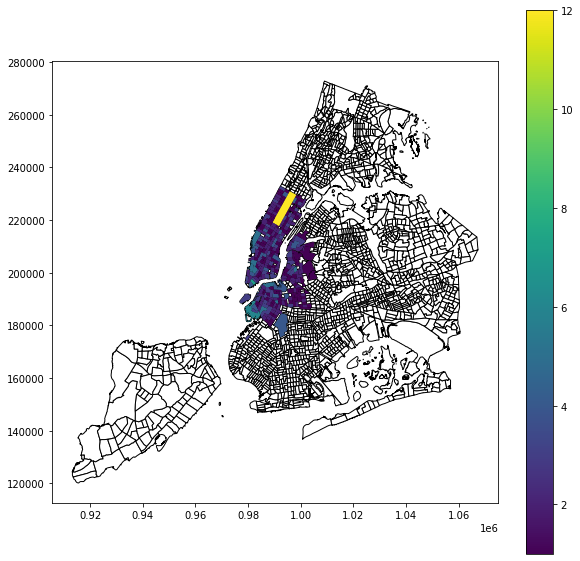

In [ ]:
ctbycs = ct_shape.merge(cbstationsWct.groupby("boro_ct2010").count()[["ntacode"]], 
                        right_index=True, left_on="boro_ct2010")
ax = ct_shape.plot(ec="k", fc="w", figsize=(10,10))
ctbycs.plot(column="ntacode_y", legend=True, ax=ax);

Caption: Coropleth of the number of bike stations per ct in New York City. 

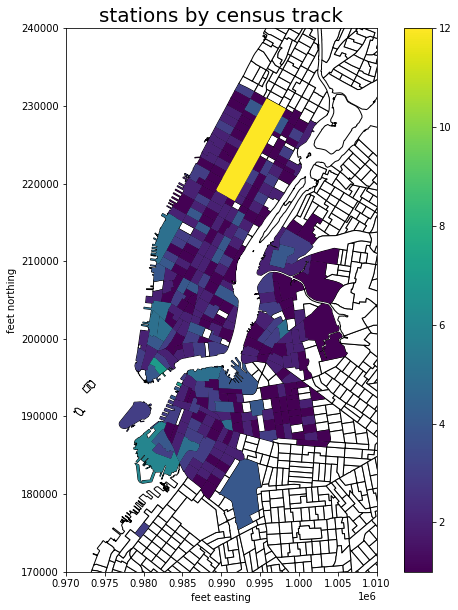

In [ ]:
#Zooming and adding labels.
ax = ct_shape.plot(ec="k", fc="w", figsize=(10,10))
ctbycs.plot(column="ntacode_y", legend=True, ax=ax);

ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
ax.set_xlim(0.97*1e6,1.01*1e6)
ax.set_ylim(170000,240000)


plt.title("stations by census tract", fontsize=20);

Caption: Coropleth of the number of bike stations per ct in New York City. This image is zoomed-in in order to focus on those ct that have bike stations. 